/tmp/ipython-input-2131080429.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")


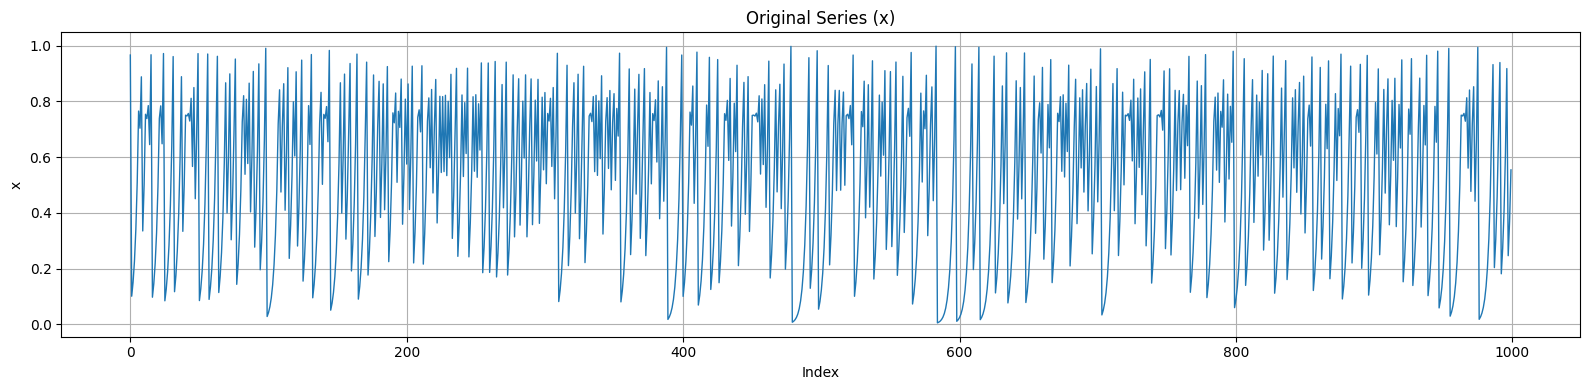

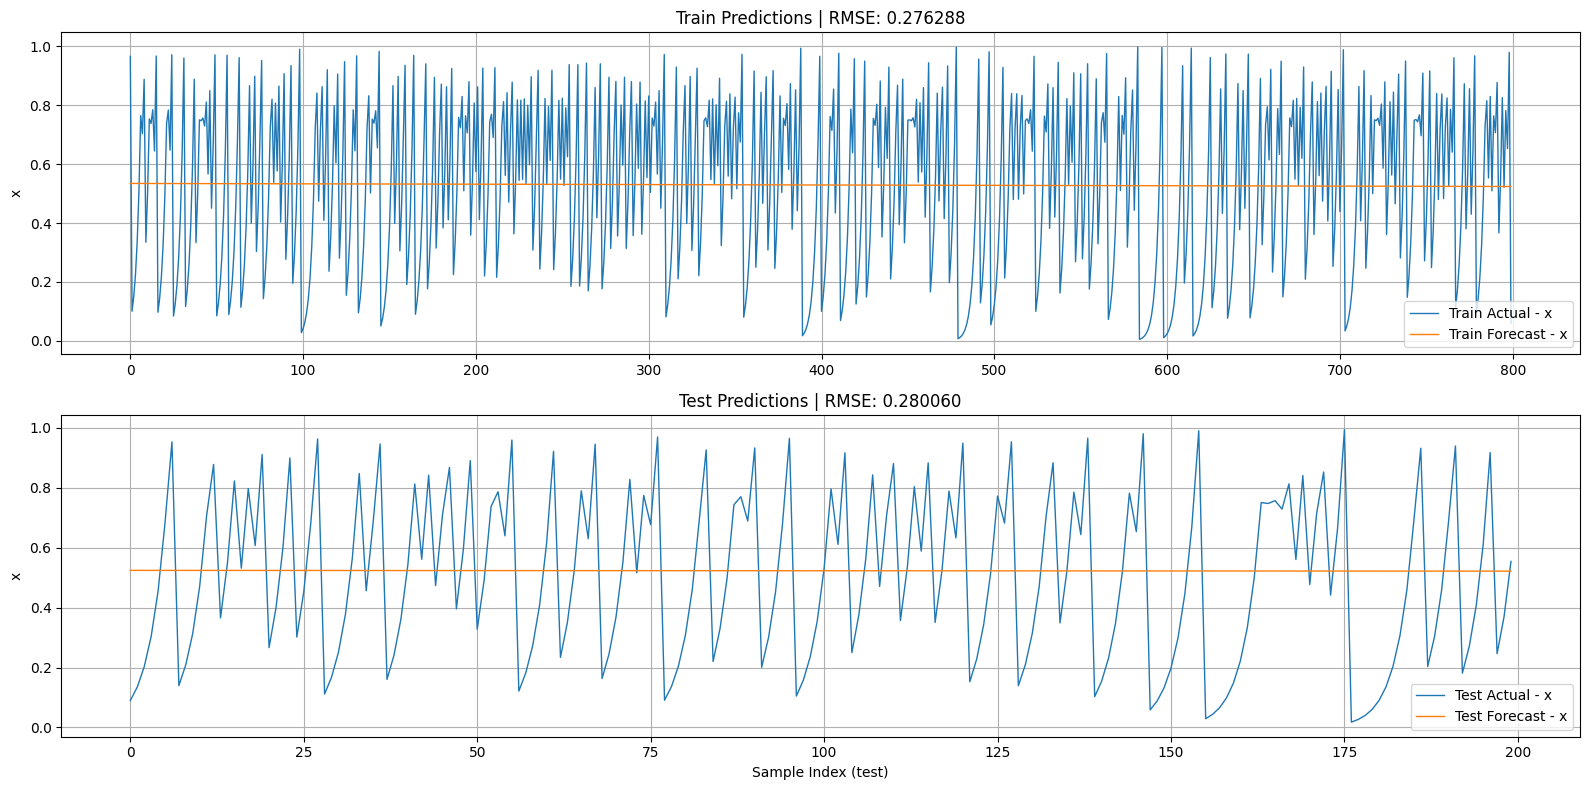

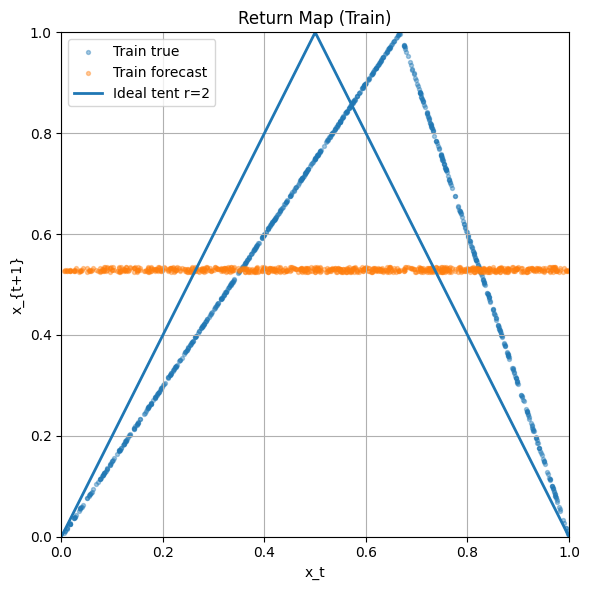

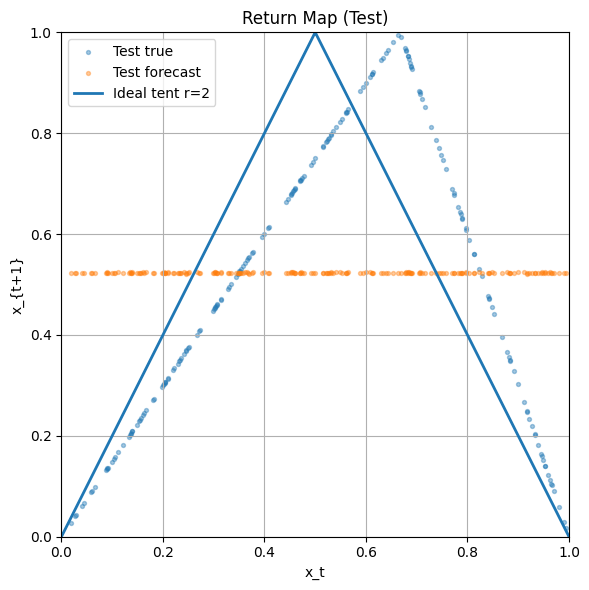

Train RMSE: 0.2762881680624364
Test RMSE: 0.2800601772612897


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os

def load_series(csv_path):
    df = pd.read_csv(csv_path)
    if "x" in df.columns:
        s = df["x"]
    else:
        if df.shape[1] == 1:
            s = pd.to_numeric(df.iloc[:, 0], errors="coerce")
        else:
            num_df = df.select_dtypes(include=[np.number])
            s = num_df.iloc[:, 0]
    s = s.fillna(method="ffill").fillna(method="bfill")
    if s.isnull().any():
        s = s.fillna(s.mean())
    return s.to_numpy().astype(np.float32)

def build_prophet_df(series):
    n = len(series)
    ds = pd.date_range(start="2000-01-01", periods=n, freq="D")
    return pd.DataFrame({"ds": ds, "y": series})

def train_test_prophet(df, split=0.8):
    n = len(df)
    cut = int(n * split)
    train_df = df.iloc[:cut].copy()
    test_df = df.iloc[cut:].copy()
    m = Prophet(
        growth="linear",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive"
    )
    m.fit(train_df)
    future = m.make_future_dataframe(periods=len(test_df), freq="D")
    forecast = m.predict(future)
    forecast_train = forecast.iloc[:cut].copy()
    forecast_test = forecast.iloc[cut:].copy()
    y_train_true = train_df["y"].to_numpy()
    y_test_true = test_df["y"].to_numpy()
    y_train_pred = forecast_train["yhat"].to_numpy()
    y_test_pred = forecast_test["yhat"].to_numpy()
    train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred) ** 2))
    test_rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
    return (
        m,
        y_train_true,
        y_train_pred,
        y_test_true,
        y_test_pred,
        train_rmse,
        test_rmse
    )

def plot_train_test_predictions(series,
                                y_train_true,
                                y_train_pred,
                                train_rmse,
                                y_test_true,
                                y_test_pred,
                                test_rmse):
    plt.figure(figsize=(16, 4))
    plt.plot(series, linewidth=1)
    plt.title("Original Series (x)")
    plt.xlabel("Index")
    plt.ylabel("x")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=False)

    ax[0].plot(y_train_true, label="Train Actual - x", linewidth=1)
    ax[0].plot(y_train_pred, label="Train Forecast - x", linewidth=1)
    ax[0].set_title(f"Train Predictions | RMSE: {train_rmse:.6f}")
    ax[0].set_ylabel("x")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(y_test_true, label="Test Actual - x", linewidth=1)
    ax[1].plot(y_test_pred, label="Test Forecast - x", linewidth=1)
    ax[1].set_title(f"Test Predictions | RMSE: {test_rmse:.6f}")
    ax[1].set_xlabel("Sample Index (test)")
    ax[1].set_ylabel("x")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_return_map(y_train_true, y_train_pred, y_test_true, y_test_pred):
    xx = np.linspace(0.0, 1.0, 500)
    tent = np.where(xx < 0.5, 2.0 * xx, 2.0 * (1.0 - xx))

    x_train = y_train_true[:-1]
    y_train_true_next = y_train_true[1:]
    y_train_pred_next = y_train_pred[1:]

    plt.figure(figsize=(6, 6))
    plt.scatter(x_train, y_train_true_next, s=8, alpha=0.4, label="Train true")
    plt.scatter(x_train, y_train_pred_next, s=8, alpha=0.4, label="Train forecast")
    plt.plot(xx, tent, linewidth=2, label="Ideal tent r=2")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x_t")
    plt.ylabel("x_{t+1}")
    plt.title("Return Map (Train)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    x_test = y_test_true[:-1]
    y_test_true_next = y_test_true[1:]
    y_test_pred_next = y_test_pred[1:]

    plt.figure(figsize=(6, 6))
    plt.scatter(x_test, y_test_true_next, s=8, alpha=0.4, label="Test true")
    plt.scatter(x_test, y_test_pred_next, s=8, alpha=0.4, label="Test forecast")
    plt.plot(xx, tent, linewidth=2, label="Ideal tent r=2")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x_t")
    plt.ylabel("x_{t+1}")
    plt.title("Return Map (Test)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def run_prophet_tent(csv_path="tent_long1.csv", split=0.8):
    series = load_series(csv_path)
    df = build_prophet_df(series)
    (
        m,
        y_train_true,
        y_train_pred,
        y_test_true,
        y_test_pred,
        train_rmse,
        test_rmse
    ) = train_test_prophet(df, split)
    plot_train_test_predictions(
        series,
        y_train_true,
        y_train_pred,
        train_rmse,
        y_test_true,
        y_test_pred,
        test_rmse
    )
    plot_return_map(y_train_true, y_train_pred, y_test_true, y_test_pred)
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    return m

if __name__ == "__main__":
    csv_path = "tent_long1.csv"
    if not os.path.exists(csv_path):
        raise SystemExit("csv not found")
    run_prophet_tent(csv_path, split=0.8)


In [3]:
!pip uninstall -y prophet fbprophet
!pip install prophet cmdstanpy


Found existing installation: prophet 1.1.7
Uninstalling prophet-1.1.7:
  Successfully uninstalled prophet-1.1.7
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 99.4 MB/s eta 0:00:00


/tmp/ipython-input-1131473059.py:17: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  s = s.fillna(method="ffill").fillna(method="bfill")


Train RMSE: 0.05100981106125891
Test RMSE: 0.053210886868385036


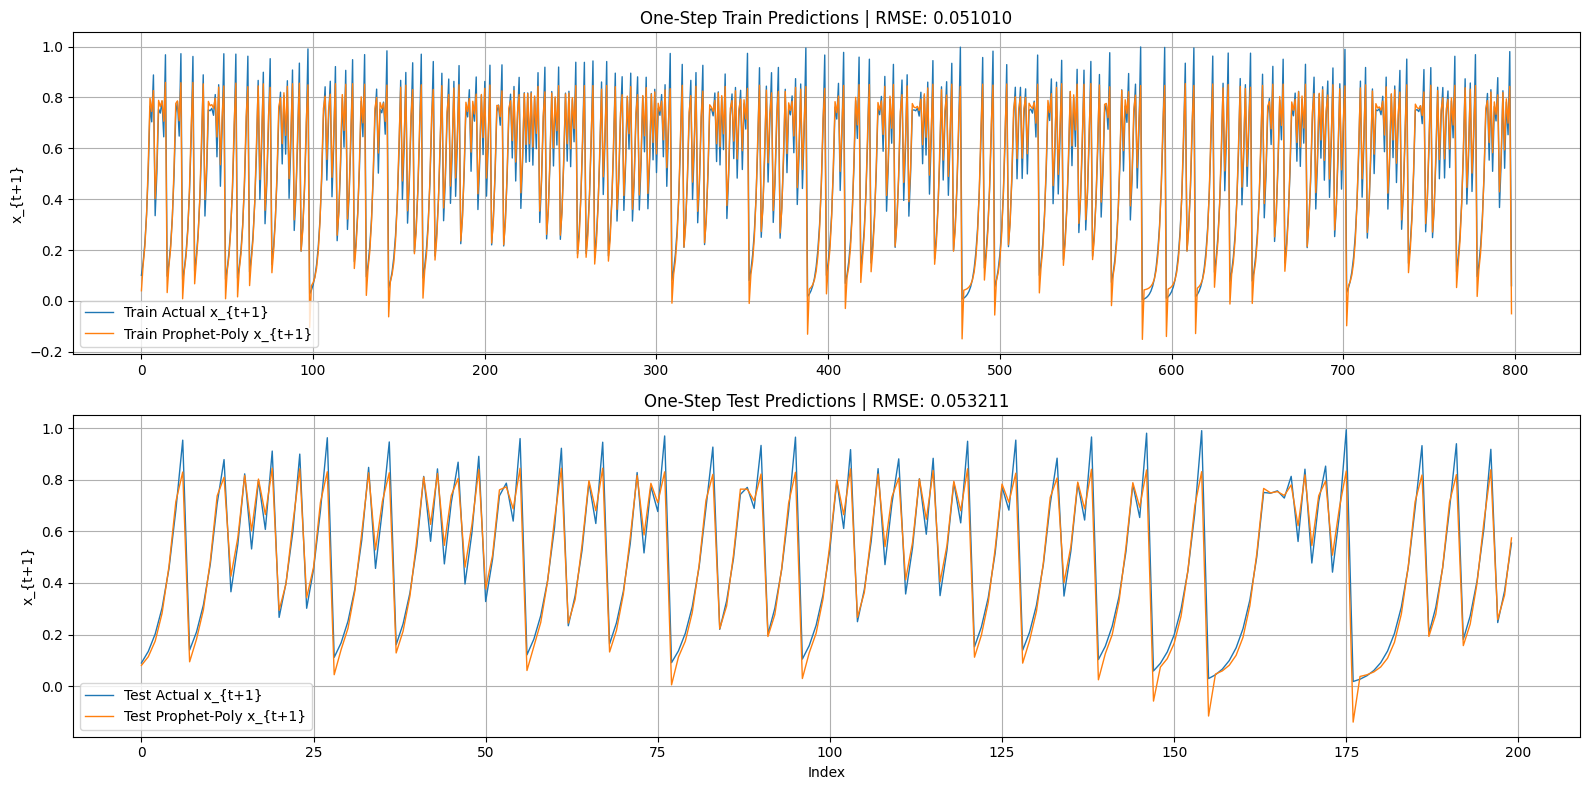

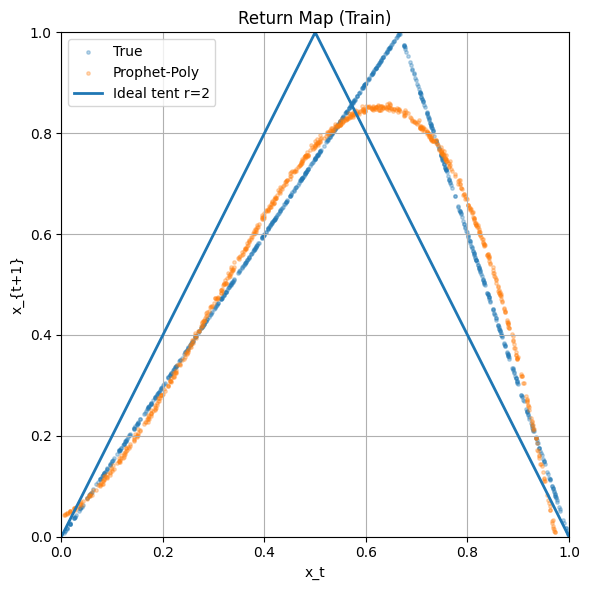

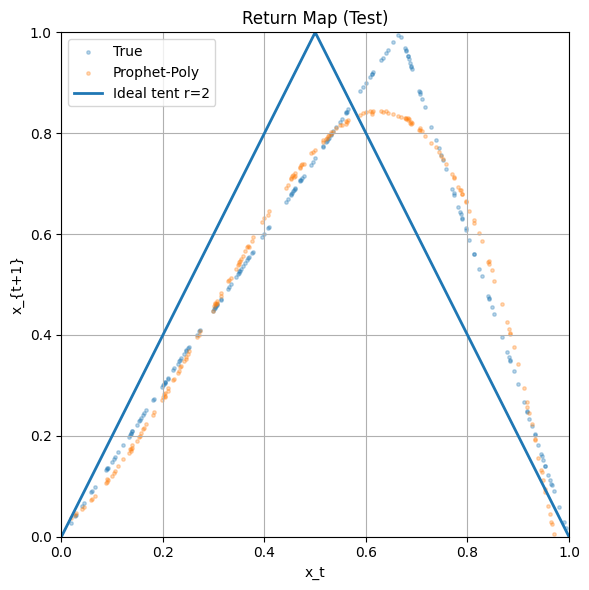

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
import os

def load_series(csv_path):
    df = pd.read_csv(csv_path)
    if "x" in df.columns:
        s = df["x"]
    else:
        if df.shape[1] == 1:
            s = pd.to_numeric(df.iloc[:, 0], errors="coerce")
        else:
            num_df = df.select_dtypes(include=[np.number])
            s = num_df.iloc[:, 0]
    s = s.fillna(method="ffill").fillna(method="bfill")
    if s.isnull().any():
        s = s.fillna(s.mean())
    return s.to_numpy().astype(np.float32)

def build_poly_df(series, degree=3):
    x_t = series[:-1]
    y_next = series[1:]
    n = len(y_next)
    ds = pd.date_range(start="2000-01-01", periods=n, freq="D")
    data = {"ds": ds, "y": y_next}
    for d in range(1, degree + 1):
        data[f"x_p{d}"] = x_t ** d
    return pd.DataFrame(data)

def train_test_prophet_poly(df, split=0.8):
    n = len(df)
    cut = int(n * split)
    train_df = df.iloc[:cut].copy()
    test_df = df.iloc[cut:].copy()
    m = Prophet(
        growth="linear",
        yearly_seasonality=False,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive"
    )
    for col in df.columns:
        if col not in ("ds", "y"):
            m.add_regressor(col)
    m.fit(train_df)
    forecast_train = m.predict(train_df)
    forecast_test = m.predict(test_df)
    y_train_true = train_df["y"].to_numpy()
    y_test_true = test_df["y"].to_numpy()
    y_train_pred = forecast_train["yhat"].to_numpy()
    y_test_pred = forecast_test["yhat"].to_numpy()
    train_rmse = np.sqrt(np.mean((y_train_true - y_train_pred) ** 2))
    test_rmse = np.sqrt(np.mean((y_test_true - y_test_pred) ** 2))
    return m, y_train_true, y_train_pred, y_test_true, y_test_pred, train_rmse, test_rmse

def plot_one_step_predictions(y_train_true, y_train_pred, y_test_true, y_test_pred, train_rmse, test_rmse):
    fig, ax = plt.subplots(2, 1, figsize=(16, 8), sharex=False)

    ax[0].plot(y_train_true, label="Train Actual x_{t+1}", linewidth=1)
    ax[0].plot(y_train_pred, label="Train Prophet-Poly x_{t+1}", linewidth=1)
    ax[0].set_title(f"One-Step Train Predictions | RMSE: {train_rmse:.6f}")
    ax[0].set_ylabel("x_{t+1}")
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot(y_test_true, label="Test Actual x_{t+1}", linewidth=1)
    ax[1].plot(y_test_pred, label="Test Prophet-Poly x_{t+1}", linewidth=1)
    ax[1].set_title(f"One-Step Test Predictions | RMSE: {test_rmse:.6f}")
    ax[1].set_xlabel("Index")
    ax[1].set_ylabel("x_{t+1}")
    ax[1].grid(True)
    ax[1].legend()

    plt.tight_layout()
    plt.show()

def plot_return_map(y_true, y_pred, title_suffix):
    xx = np.linspace(0.0, 1.0, 500)
    tent = np.where(xx < 0.5, 2.0 * xx, 2.0 * (1.0 - xx))
    x_t = y_true[:-1]
    y_true_next = y_true[1:]
    y_pred_next = y_pred[1:]
    plt.figure(figsize=(6, 6))
    plt.scatter(x_t, y_true_next, s=6, alpha=0.3, label="True")
    plt.scatter(x_t, y_pred_next, s=6, alpha=0.3, label="Prophet-Poly")
    plt.plot(xx, tent, linewidth=2, label="Ideal tent r=2")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.xlabel("x_t")
    plt.ylabel("x_{t+1}")
    plt.title(f"Return Map ({title_suffix})")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

def run_prophet_tent_poly(csv_path="tent_long1.csv", split=0.8, degree=3):
    series = load_series(csv_path)
    df = build_poly_df(series, degree=degree)
    m, y_train_true, y_train_pred, y_test_true, y_test_pred, train_rmse, test_rmse = train_test_prophet_poly(df, split)
    print("Train RMSE:", train_rmse)
    print("Test RMSE:", test_rmse)
    plot_one_step_predictions(y_train_true, y_train_pred, y_test_true, y_test_pred, train_rmse, test_rmse)
    plot_return_map(y_train_true, y_train_pred, "Train")
    plot_return_map(y_test_true, y_test_pred, "Test")
    return m

if __name__ == "__main__":
    csv_path = "tent_long1.csv"
    if not os.path.exists(csv_path):
        raise SystemExit("csv not found")
    run_prophet_tent_poly(csv_path, split=0.8, degree=3)
